<a href="https://colab.research.google.com/github/MahyarFardin/Deep-white-noise-elimination-using-recurrent-and-convolutional-generative-adversial-networks/blob/main/dataset_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import shutil
import librosa
import librosa.display
import IPython.display as ipd

In [35]:
#!git clone https://github.com/microsoft/MS-SNSD.git

In [36]:
# dataset_folders = ["clean_test", "clean_train", "noise_test", "noise_train", "hitapps"]
# repo_path = "MS-SNSD"
# drive_path = "/content/drive/MyDrive/White Noise project/Dataset"

# for folder in dataset_folders:
#   source = os.path.join(repo_path, folder)
#   destination = os.path.join(drive_path, folder)
#   shutil.copytree(source, destination)
#   print(f"{folder} copied to google drive")

In [37]:
# shutil.rmtree(repo_path)
# print("cloned repository deleted from colab's memory")

In [3]:
clean_sample = "/content/drive/MyDrive/White Noise project/Dataset/clean_train/p234_034.wav"
noise_sample = "/content/drive/MyDrive/White Noise project/Dataset/noise_train/AirConditioner_4.wav"

signal_clean, sr = librosa.load(clean_sample, sr = 44100, duration = 4)
signal_noise, _ = librosa.load(noise_sample, sr = 44100, duration = 4)

In [40]:
# Constants defining parameters for frame-based analysis of time-domain signals
FRAME_LENGTH = 512
HOP_LENGTH = 256

In [41]:
ipd.Audio(clean_sample)

In [42]:
ipd.Audio(noise_sample)

In [43]:
print(signal_clean.shape)
print(signal_noise.shape)

(176400,)
(176400,)


In [44]:
def plot_samples(signal_clean, signal_noise, sr):
  plt.figure(figsize = (12,7))

  #plot the sample_clean
  plt.subplot(2, 1, 1)
  librosa.display.waveshow(signal_clean, sr = sr, alpha = 0.5)
  plt.ylim((-1,1))
  plt.title("Sample without noise")
  plt.xlabel("Time")
  plt.ylabel("Amplitude")


  #plot the sample_noise
  plt.subplot(2, 1, 2)
  librosa.display.waveshow(signal_noise, sr = sr, alpha = 0.5)
  plt.ylim((-1,1))
  plt.title("Sample noise")
  plt.xlabel("Time")
  plt.ylabel("Amplitude")

  plt.tight_layout()
  plt.show()

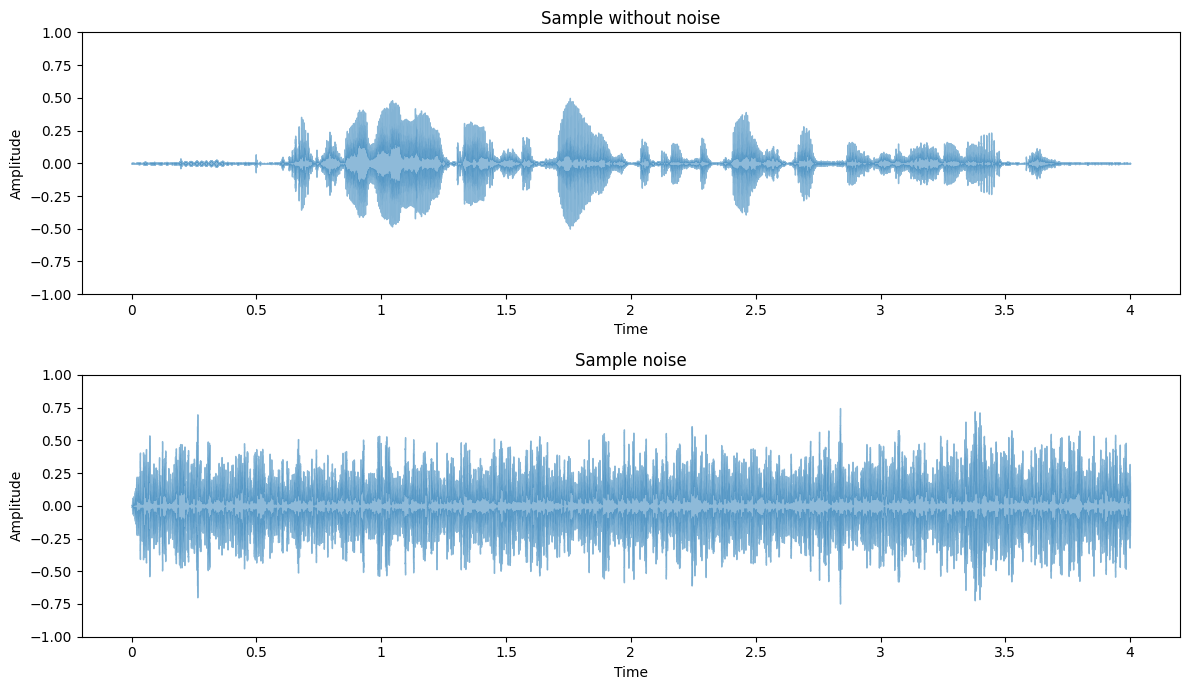

In [45]:
plot_samples(signal_clean, signal_noise, sr)

In [46]:
def amplitude_envelope(signal, frame_length = FRAME_LENGTH, hop_length = HOP_LENGTH):
  """
    Computes the amplitude envelope of a signal.

    Parameters:
    - signal (numpy.ndarray): The input signal.
    - frame_length (int, optional): The size of each analysis frame. Defaults to FRAME_LENGTH(1024).
    - hop_length (int, optional): The number of samples between adjacent frames. Defaults to HOP_LENGTH(512).

    Returns:
    - numpy.ndarray: An array containing the maximum amplitude value within each frame.
  """
  return np.array([max(signal[i:i+frame_length]) for i in range(0, signal.size, hop_length)])

In [47]:
# Calculate the amplitude envelope for both clean and noise signals

ae_signal_clean = amplitude_envelope(signal_clean, FRAME_LENGTH, HOP_LENGTH)
ae_signal_noise = amplitude_envelope(signal_noise, FRAME_LENGTH, HOP_LENGTH)

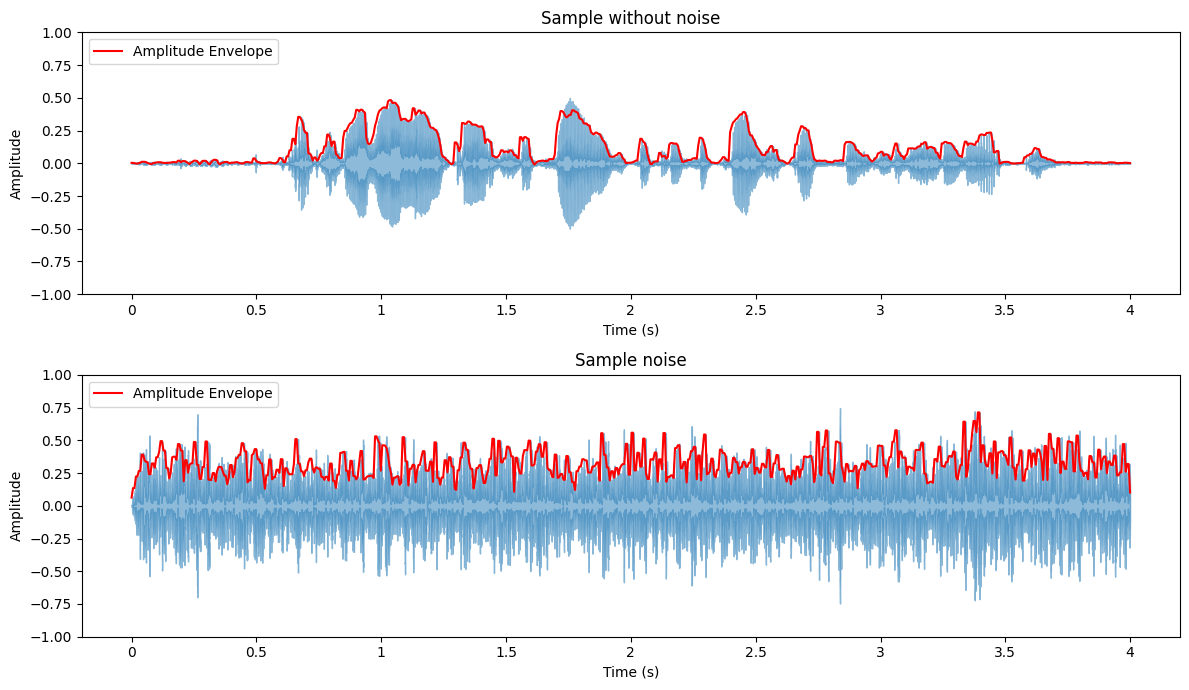

In [48]:
# Convert frame indices to time values
frames = range(len(ae_signal_clean))
time = librosa.frames_to_time(frames, hop_length = HOP_LENGTH)/2


# Plot the amplitude envelope for both samples, with and without noise
plt.figure(figsize = (12,7))

plt.subplot(2, 1, 1)
librosa.display.waveshow(signal_clean, sr = sr, alpha = 0.5)
plt.plot(time, ae_signal_clean, color = "r", label="Amplitude Envelope")
plt.ylim((-1 , 1))
plt.title("Sample without noise")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc = "upper left")

plt.subplot(2, 1, 2)
librosa.display.waveshow(signal_noise, sr = sr, alpha = 0.5)
plt.plot(time, ae_signal_noise, color = "r", label="Amplitude Envelope")
plt.ylim((-1 , 1))
plt.title("Sample noise")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc = "upper left")


plt.tight_layout()
plt.show()

In [49]:
def rms(signal, frame_length, hop_length):
  """
    Compute the root mean square (RMS) energy for each analysis frame in a signal.

    Parameters:
    - signal (numpy.ndarray): The input signal.
    - frame_length (int): The size of each analysis frame.
    - hop_length (int): The number of samples between adjacent frames.

    Returns:
    - numpy.ndarray: An array containing the RMS energy for each frame.
  """
  rms = []

  for i in range(0, len(signal), hop_length):
    rms_current_frame = np.sqrt((np.sum(signal[i:i+frame_length]**2)) / frame_length)
    rms.append(rms_current_frame)

  return np.array(rms)

In [50]:
# Calculate the Root Mean Square (RMS) energy for both clean and noise signals

rms_signal_clean = rms(signal_clean, FRAME_LENGTH, HOP_LENGTH)
rms_signal_noise = rms(signal_noise, FRAME_LENGTH, HOP_LENGTH)

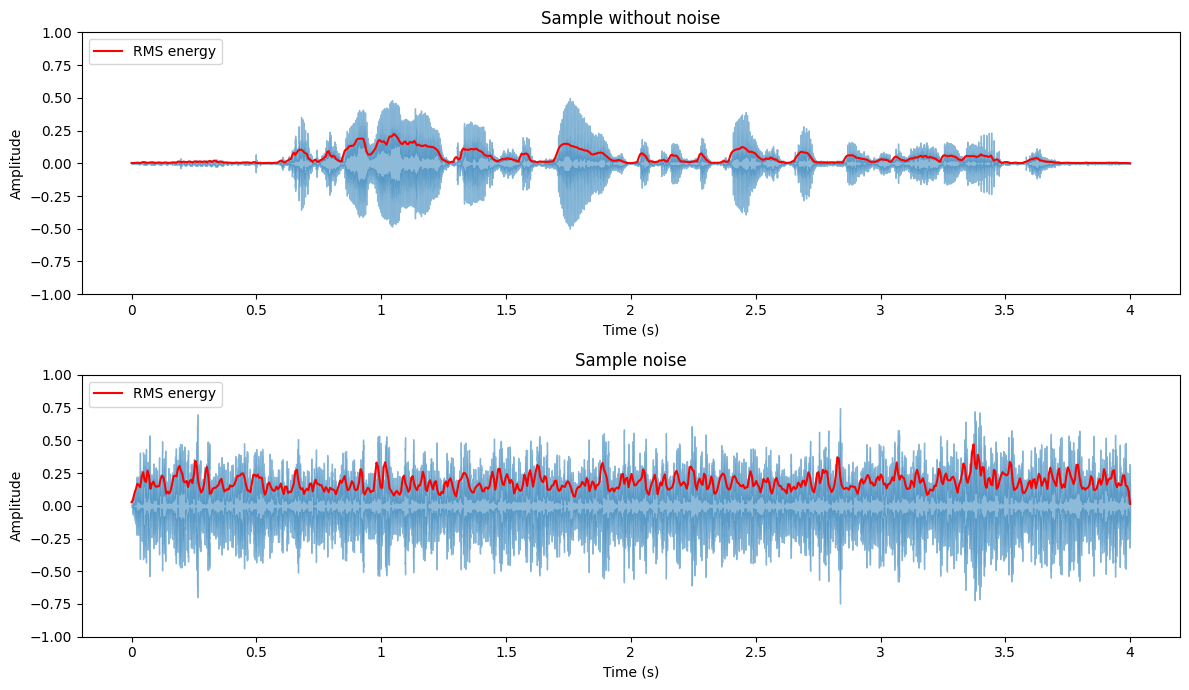

In [51]:
# Convert frame indices to time values
frames = range(len(rms_signal_clean))
time = librosa.frames_to_time(frames, hop_length = HOP_LENGTH)/2

# Plotting the root-mean-square energy (RMSE) for both clean and noise signals over time
plt.figure(figsize = (12,7))

plt.subplot(2, 1, 1)
librosa.display.waveshow(signal_clean, sr = sr, alpha = 0.5)
plt.plot(time, rms_signal_clean, color = "r", label="RMS energy")
plt.ylim((-1 , 1))
plt.title("Sample without noise")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc = "upper left")

plt.subplot(2, 1, 2)
librosa.display.waveshow(signal_noise, sr = sr, alpha = 0.5)
plt.plot(time, rms_signal_noise, color = "r", label="RMS energy")
plt.ylim((-1 , 1))
plt.title("Sample noise")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc = "upper left")


plt.tight_layout()
plt.show()

In [52]:
# Calculate the Zero Crossing Rate (ZCR) for both clean and noise signals

zcr_signal_clean = librosa.feature.zero_crossing_rate(signal_clean, frame_length = FRAME_LENGTH, hop_length = HOP_LENGTH)[0]
zcr_signal_noise = librosa.feature.zero_crossing_rate(signal_noise, frame_length = FRAME_LENGTH, hop_length = HOP_LENGTH)[0]

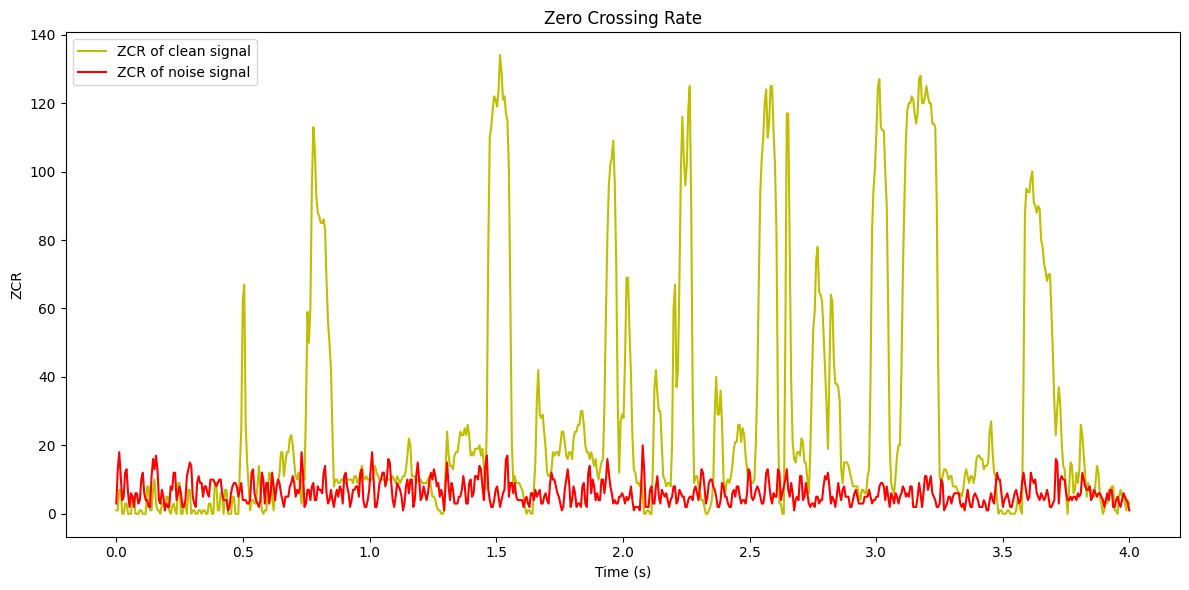

In [53]:
# Convert frame indices to time values
frames = range(len(zcr_signal_clean))
time = librosa.frames_to_time(frames, hop_length = HOP_LENGTH)/2


# Plotting the Zero Crossing Rate (ZCR) for both clean and noise signals over time

plt.figure(figsize = (12,6))
plt.plot(time, zcr_signal_clean * FRAME_LENGTH, color = "y", label = "ZCR of clean signal")
plt.plot(time, zcr_signal_noise * FRAME_LENGTH, color = "r", label = "ZCR of noise signal")
plt.title("Zero Crossing Rate")
plt.xlabel("Time (s)")
plt.ylabel("ZCR")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()


In [54]:
def plot_magnitude_spectrum(magnitude_spectrum, sr, title, frequency_ration = 1):
  """
    Plot the magnitude spectrum.

    Parameters:
    - magnitude_spectrum (numpy.ndarray): The magnitude spectrum to be plotted.
    - sr (int): The sampling rate of the audio signal.
    - title (str): The title of the plot.
    - frequency_ratio (float, optional): The ratio of frequencies to be plotted. Defaults to 1.

    Returns:
    - None
  """
  plt.figure(figsize = (12 , 4))

  frequency = np.linspace(0, sr, len(magnitude_spectrum))
  num_frequency_bins = int(len(frequency) * frequency_ration)
  plt.plot(frequency[0:num_frequency_bins], magnitude_spectrum[0:num_frequency_bins])
  plt.title(title)
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Magnitude")

  plt.tight_layout()
  plt.show()

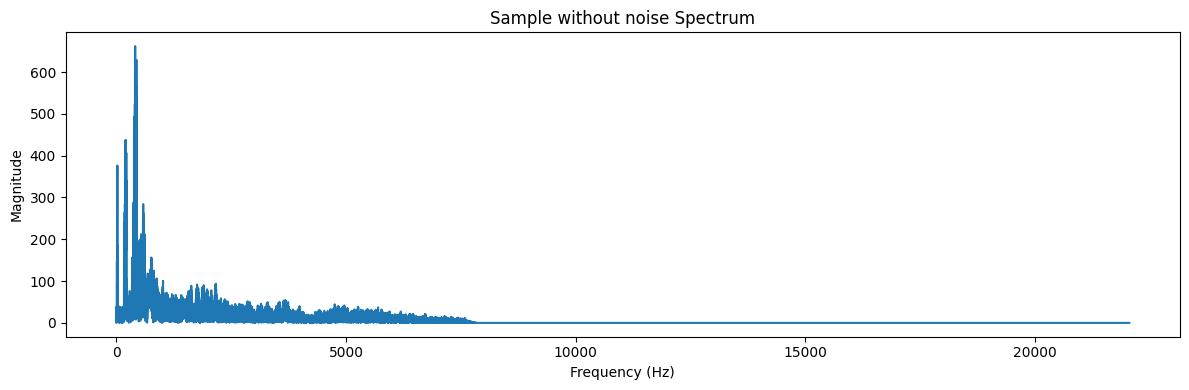

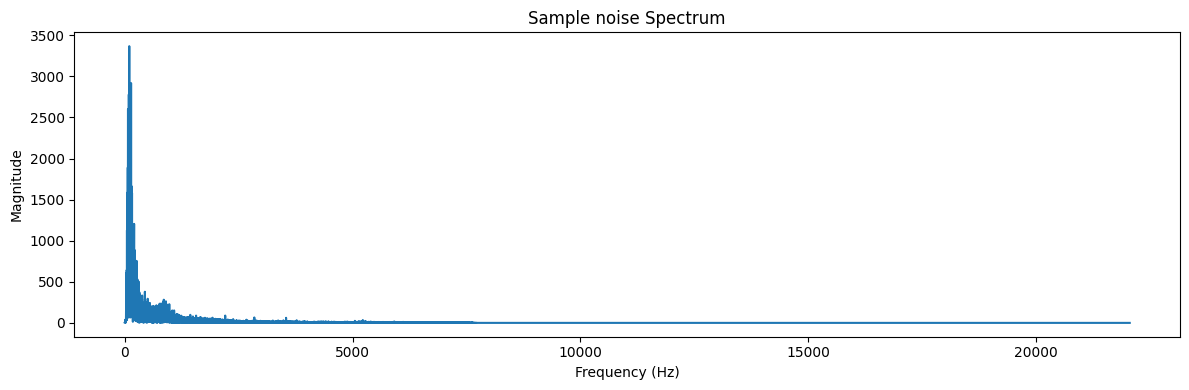

In [55]:
# compute the fast fourier transform of both signals
ft_signal_clean = np.fft.fft(signal_clean)
ft_signal_noise = np.fft.fft(signal_noise)

# extract magnitude spectrum of the signals
magnitude_spectrum_clean = np.abs(ft_signal_clean)
magnitude_spectrum_noise = np.abs(ft_signal_noise)

# Plot the magnitude spectrum of the signals
plot_magnitude_spectrum(magnitude_spectrum_clean, sr, "Sample without noise Spectrum", 0.5)
plot_magnitude_spectrum(magnitude_spectrum_noise, sr, "Sample noise Spectrum", 0.5)

In [56]:
def plot_spectrogram(spectrogram, sr, hop_length, y_axis = "log", title = "Log Spactrogram"):
  """
    Plot a spectrogram.

    Parameters:
    - spectrogram (numpy.ndarray): The input spectrogram to be plotted.
    - sr (int): The sampling rate of the audio signal.
    - hop_length (int): The number of samples between successive frames.
    - y_axis (str, optional): The scale of the frequency axis. Defaults to "log".
    - title (str, optional): The title of the plot. Defaults to "Spectrogram".

    Returns:
    - None
  """

  plt.figure(figsize = (17,6))
  librosa.display.specshow(spectrogram, sr = sr, hop_length = hop_length, x_axis = "time", y_axis = y_axis,)
  plt.title(title)
  plt.ylabel("Frequency (Hz)")
  plt.xlabel("Time (s)")
  colorbar = plt.colorbar()
  colorbar.set_label('Intensity')
  plt.show()

In [57]:
# extract short time fourier transform (STFT) of both signals
stft_signal_clean = librosa.stft(signal_clean, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
stft_signal_noise = librosa.stft(signal_noise, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)

# extract spectrogram of the signals
spectrogram_clean = librosa.power_to_db(np.abs(stft_signal_clean) ** 2)
spectrogram_noise = librosa.power_to_db(np.abs(stft_signal_noise) ** 2)

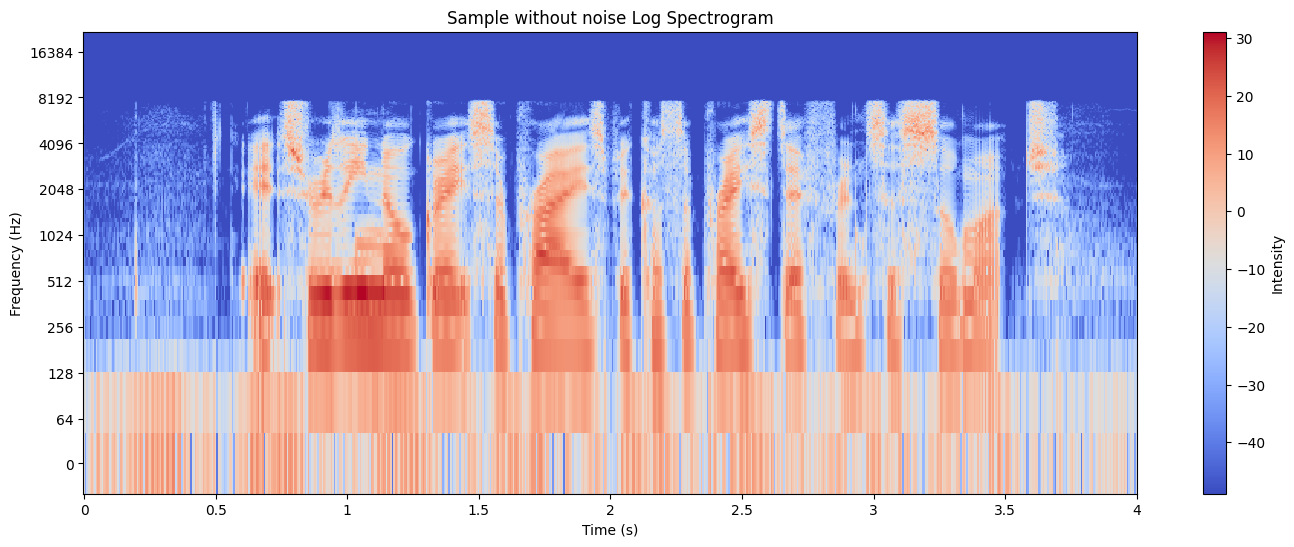

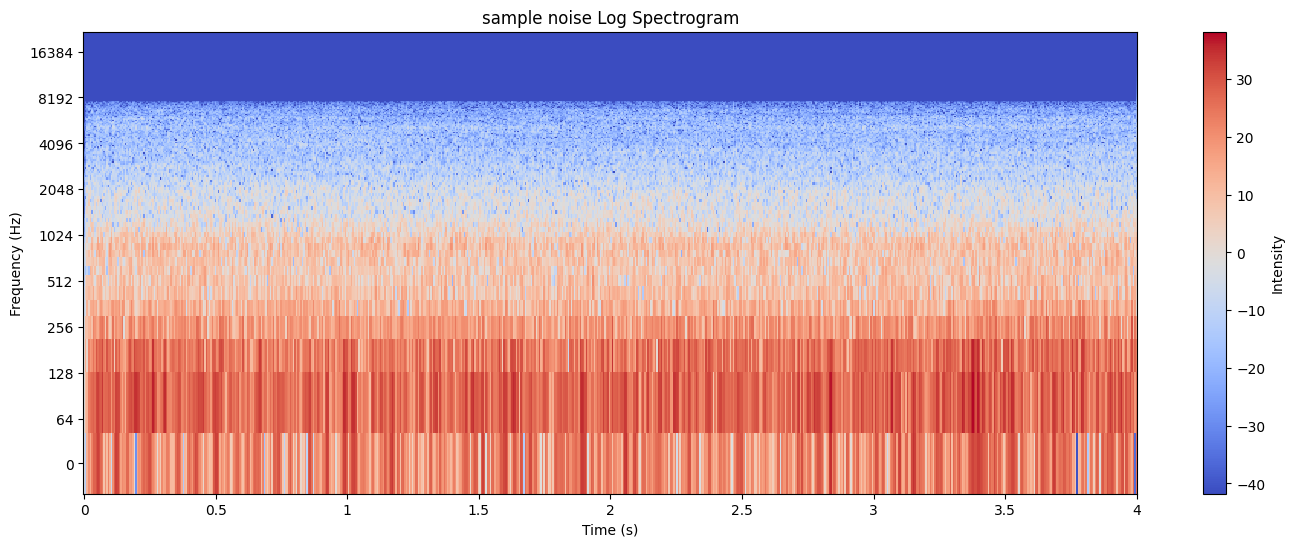

In [58]:
# Plot the log spectrograms of the signals

plot_spectrogram(spectrogram_clean, sr, HOP_LENGTH, "log", title="Sample without noise Log Spectrogram")
plot_spectrogram(spectrogram_noise, sr, HOP_LENGTH, "log", title="sample noise Log Spectrogram")

In [59]:
def plot_mel_spectrogram(mel_spectrogram, sr, title = "Log Mel Spectrogram"):
  """
    Plots a logarithmic Mel spectrogram.

    Parameters:
        mel_spectrogram (numpy.ndarray): The logarithmic Mel spectrogram to be plotted.
        sr (int): The sampling rate of the audio.
        title (str, optional): Title of the plot. Defaults to "Log Mel Spectrogram".

    Returns:
        None
  """

  plt.figure(figsize = (17,6))
  librosa.display.specshow(mel_spectrogram, sr = sr, x_axis = "time", y_axis = "mel")
  plt.title(title)
  plt.xlabel("Time (s)")
  plt.ylabel("Mel Frequency")
  colorbar = plt.colorbar()
  colorbar.set_label('Magnitude')

In [60]:
# Extract Mel Spectrogram of the signals

mel_spectrogram_clean = librosa.feature.melspectrogram(y = signal_clean, sr = sr, n_fft = FRAME_LENGTH, hop_length = HOP_LENGTH, n_mels = 90)# n_mels needs to be modified for our task by sevral tests
mel_spectrogram_noise = librosa.feature.melspectrogram(y = signal_noise, sr = sr, n_fft = FRAME_LENGTH, hop_length = HOP_LENGTH, n_mels = 90)

mel_spectrogram_clean.shape # (number of mal bands, number of frames)

(90, 690)

In [61]:
# Change the mal_spectrograms scale to logarithmic

log_mel_spectrogram_clean = librosa.power_to_db(mel_spectrogram_clean)
log_mel_spectrogram_noise = librosa.power_to_db(mel_spectrogram_noise)

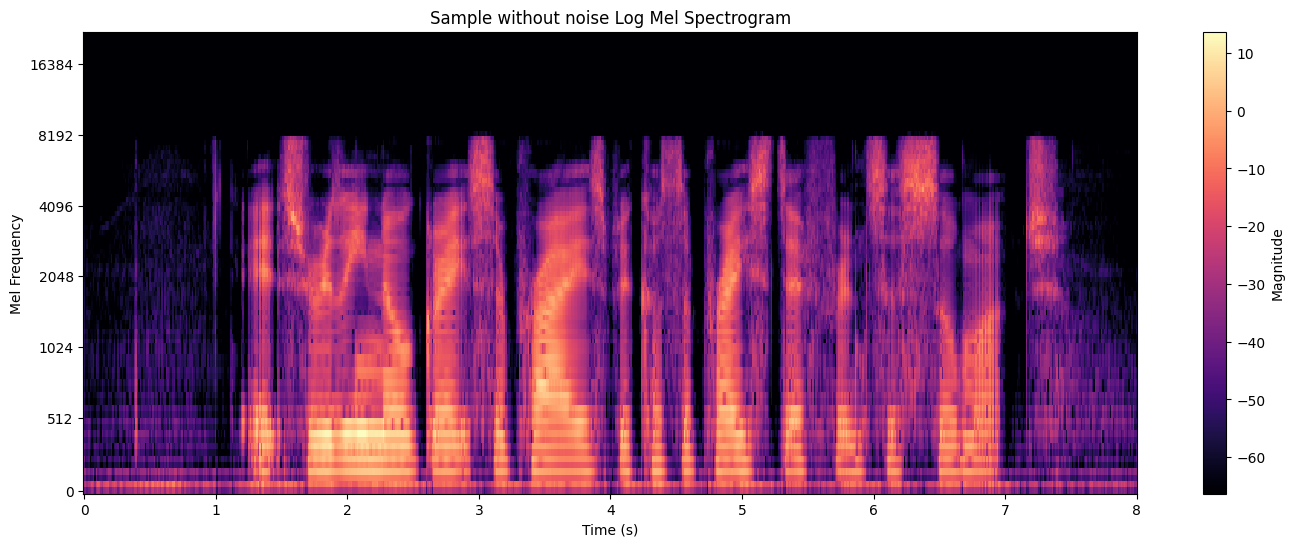

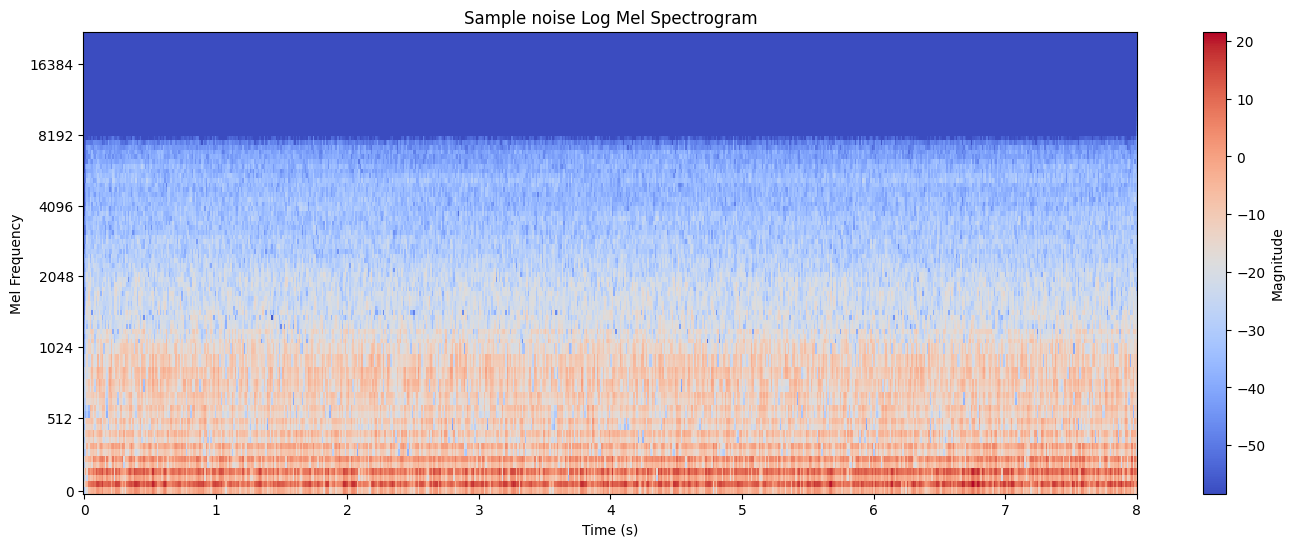

In [62]:
# Plot the log mel spectrograms of the signals

plot_mel_spectrogram(log_mel_spectrogram_clean, sr, title = "Sample without noise Log Mel Spectrogram")
plot_mel_spectrogram(log_mel_spectrogram_noise, sr, title = "Sample noise Log Mel Spectrogram")

In [63]:
def plot_mfccs(mfccs, sr, title):
  """
    Plot Mel-Frequency Cepstral Coefficients (MFCCs) spectrogram.

    Parameters:
    mfccs (numpy.ndarray): MFCCs array of shape (n_mfcc, n_frames).
    sr (int): Sampling rate of the audio signal.
    title (str): Title of the plot.

    Returns:
    None
  """

  plt.figure(figsize = (14,6))
  librosa.display.specshow(mfccs, sr = sr, x_axis = "time")
  plt.title(title)
  colorbar = plt.colorbar(format='%+2.0f dB')
  colorbar.set_label('Magnitude (dB)')
  plt.tight_layout()

In [64]:
# Extract Mel_Frequency Cepstral Coefficients(MFCCs) of the signals

mfccs_clean = librosa.feature.mfcc(y = signal_clean, sr = sr, n_mfcc = 13)
mfccs_noise = librosa.feature.mfcc(y = signal_noise, sr = sr, n_mfcc = 13)

mfccs_clean.shape

(13, 345)

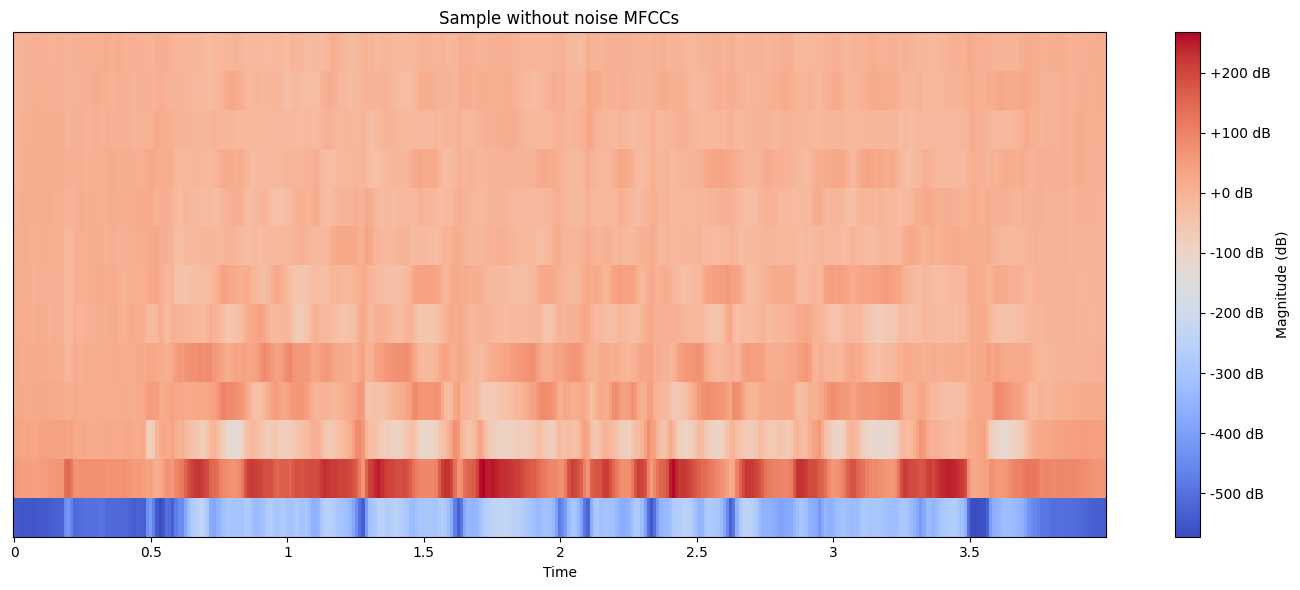

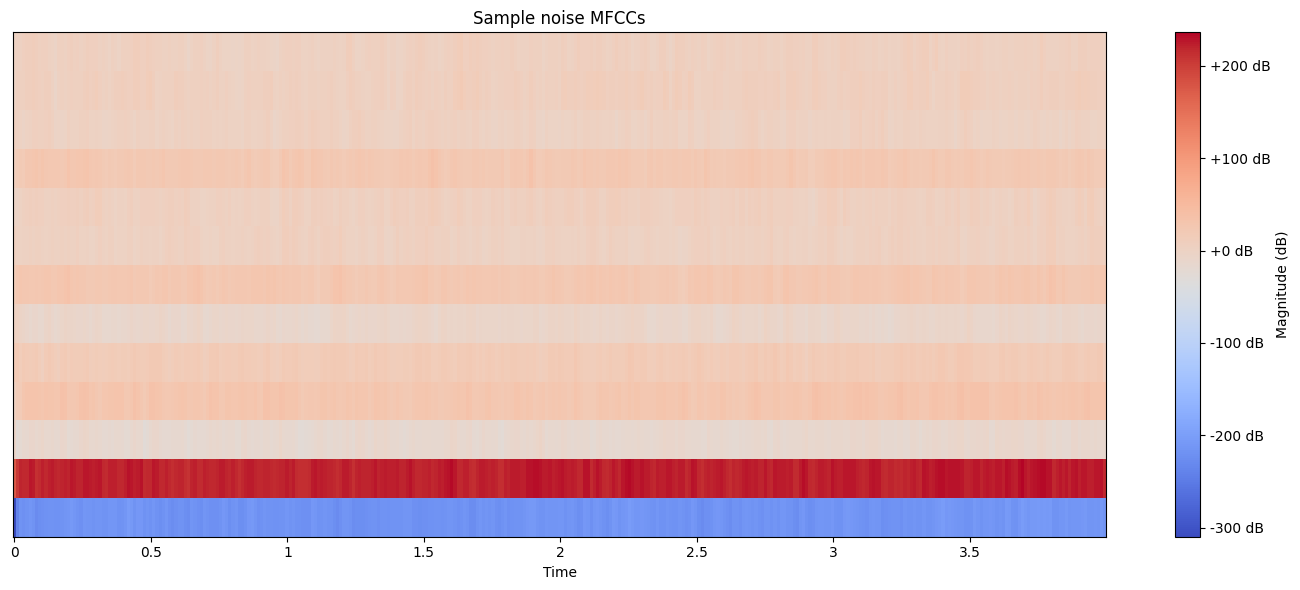

In [65]:
# Plot the MFCCs of the signals

plot_mfccs(mfccs_clean, sr, title = "Sample without noise MFCCs")
plot_mfccs(mfccs_noise, sr, title = "Sample noise MFCCs")

In [66]:
# Calculate delta and delta2 MFCCs (first and second derivative of the MFCCs) of the signals

delta_mfccs_clean = librosa.feature.delta(mfccs_clean)
delta_mfccs_noise = librosa.feature.delta(mfccs_noise)

delta2_mfccs_clean = librosa.feature.delta(mfccs_clean, order = 2)
delta2_mfccs_noise = librosa.feature.delta(mfccs_noise, order = 2)

delta_mfccs_clean.shape

(13, 345)

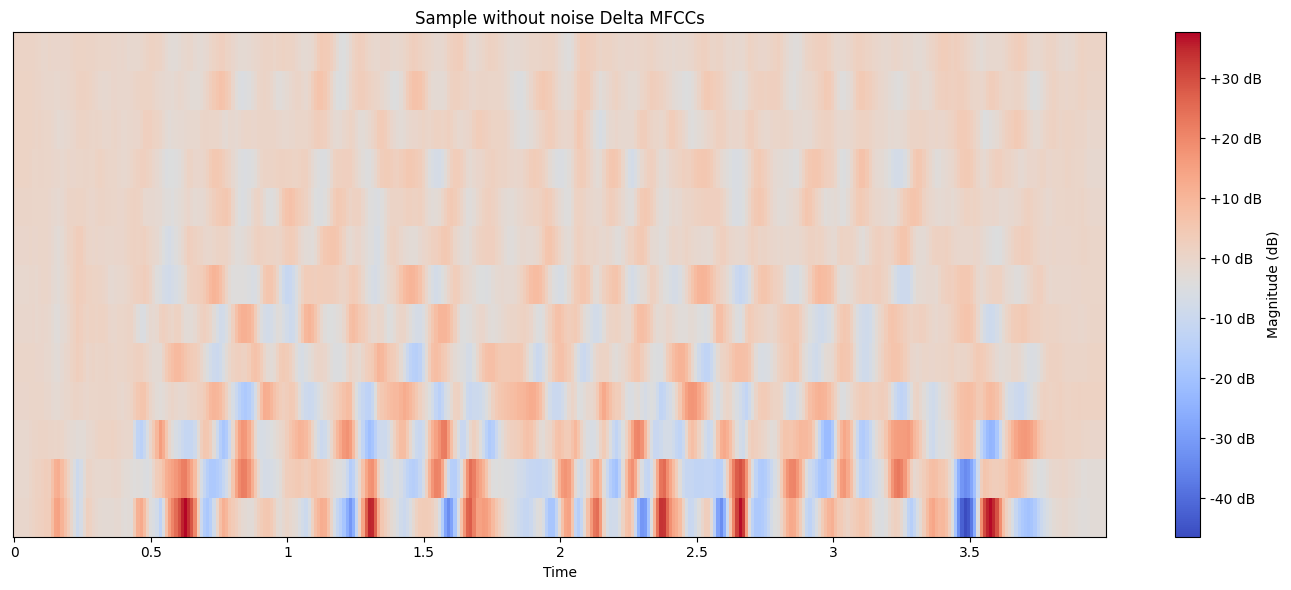

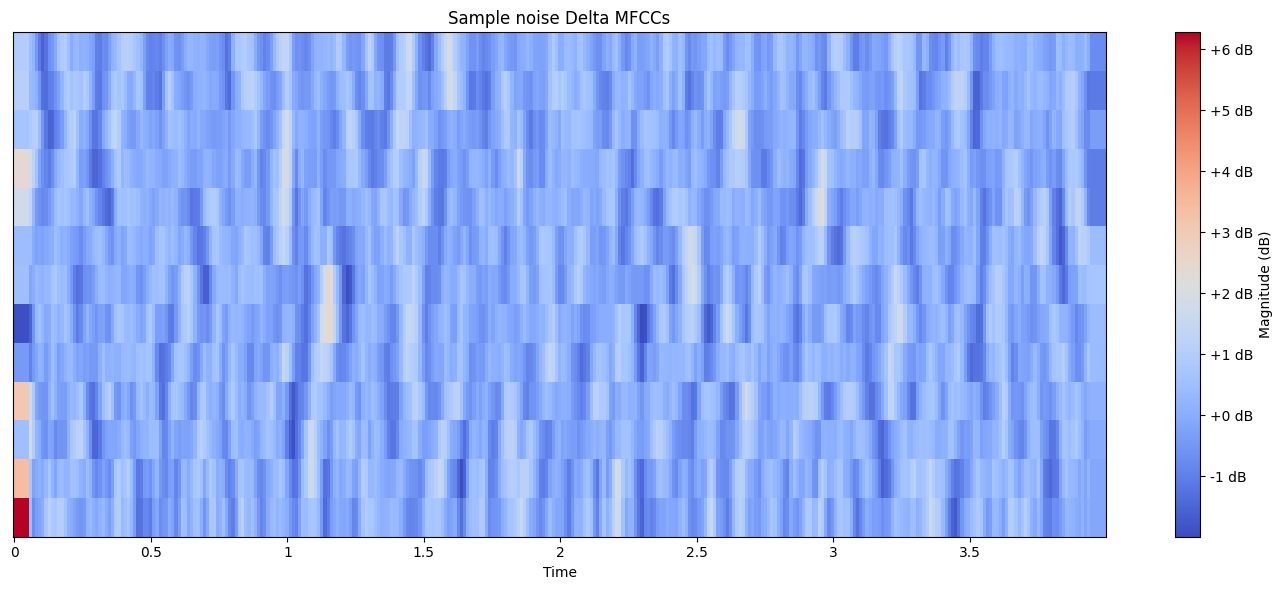

In [67]:
# Plot the delta MFCCs of the signals

plot_mfccs(delta_mfccs_clean, sr, title = "Sample without noise Delta MFCCs")
plot_mfccs(delta_mfccs_noise, sr, title = "Sample noise Delta MFCCs")

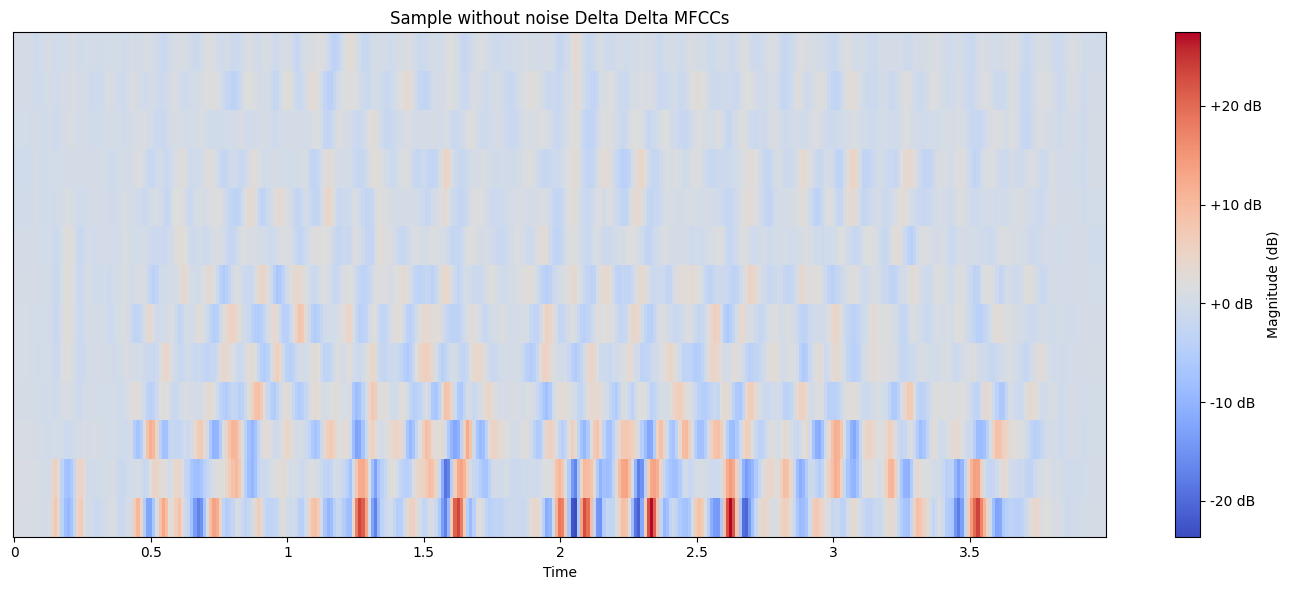

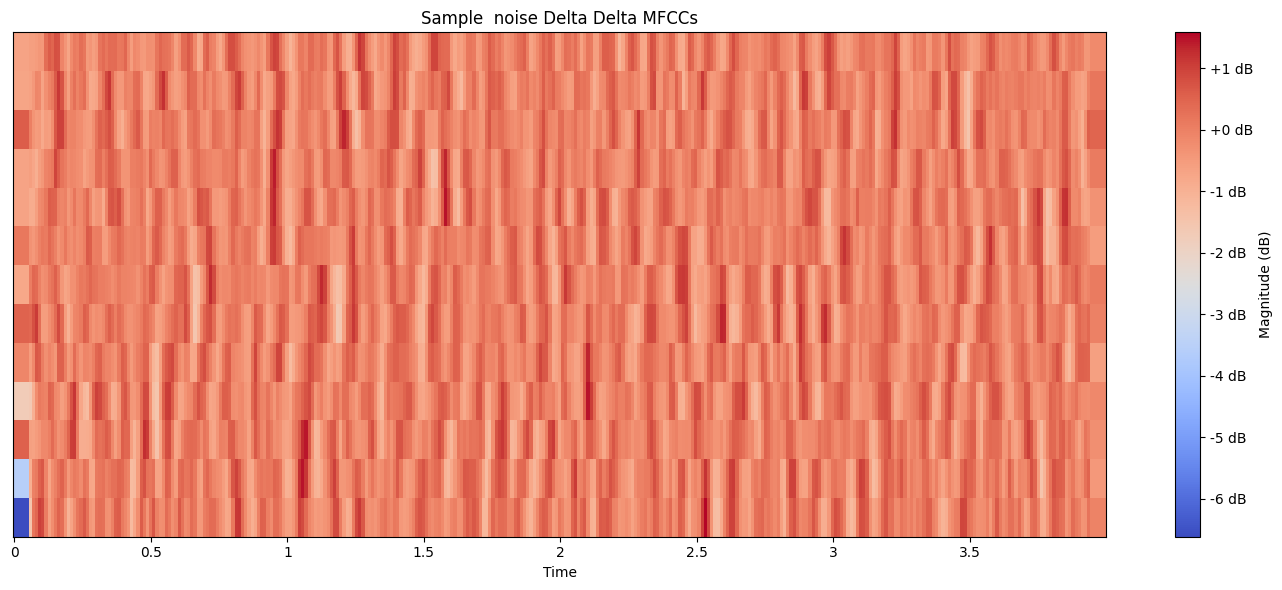

In [68]:
# Plot the delta2 MFCCs of the signals

plot_mfccs(delta2_mfccs_clean, sr, title = "Sample without noise Delta Delta MFCCs")
plot_mfccs(delta2_mfccs_noise, sr, title = "Sample  noise Delta Delta MFCCs")

In [69]:
# Extract Spectral Centroid of the signals

sc_clean = librosa.feature.spectral_centroid(y = signal_clean, sr = sr, n_fft = FRAME_LENGTH, hop_length = HOP_LENGTH)[0]
sc_noise = librosa.feature.spectral_centroid(y = signal_noise, sr = sr, n_fft = FRAME_LENGTH, hop_length = HOP_LENGTH)[0]

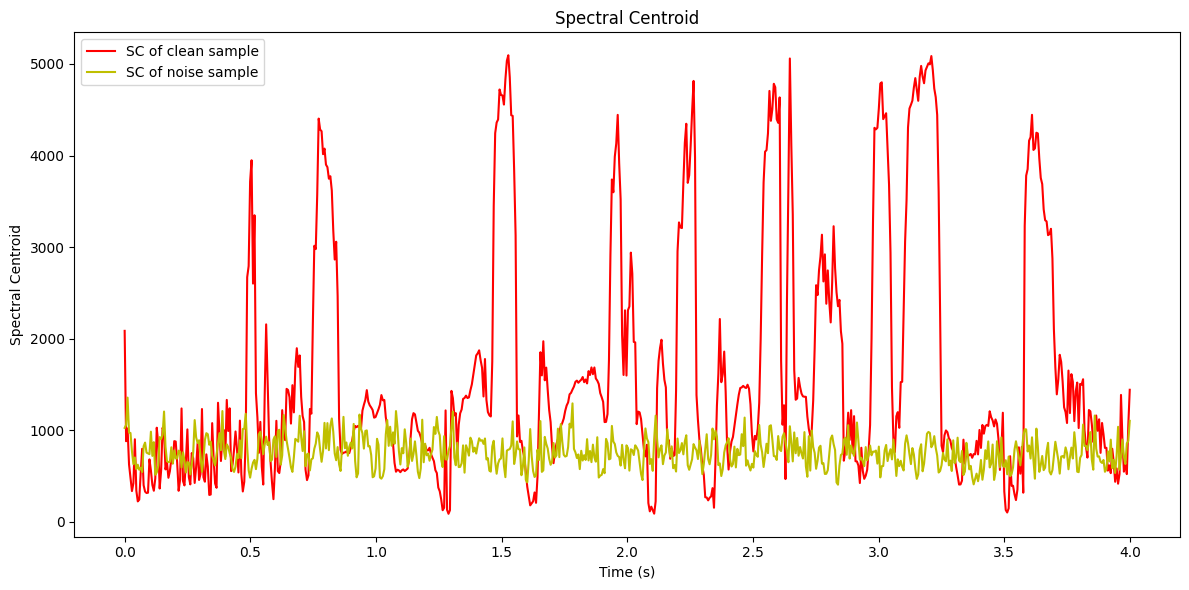

In [72]:
# Convert frame indices to time values
frames = range(len(sc_clean))
time = librosa.frames_to_time(frames, hop_length = HOP_LENGTH)/2


# Plot the spectral centroids

plt.figure(figsize = (12 , 6))
plt.plot(time, sc_clean, color = "r", label = "SC of clean sample")
plt.plot(time, sc_noise, color = "y", label = "SC of noise sample")
plt.title("Spectral Centroid")
plt.xlabel("Time (s)")
plt.ylabel("Spectral Centroid")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

In [73]:
# Calculate Bandwidth

bw_clean = librosa.feature.spectral_bandwidth(y = signal_clean, sr = sr, n_fft = FRAME_LENGTH, hop_length = HOP_LENGTH)[0]
bw_noise = librosa.feature.spectral_bandwidth(y = signal_noise, sr = sr, n_fft = FRAME_LENGTH, hop_length = HOP_LENGTH)[0]

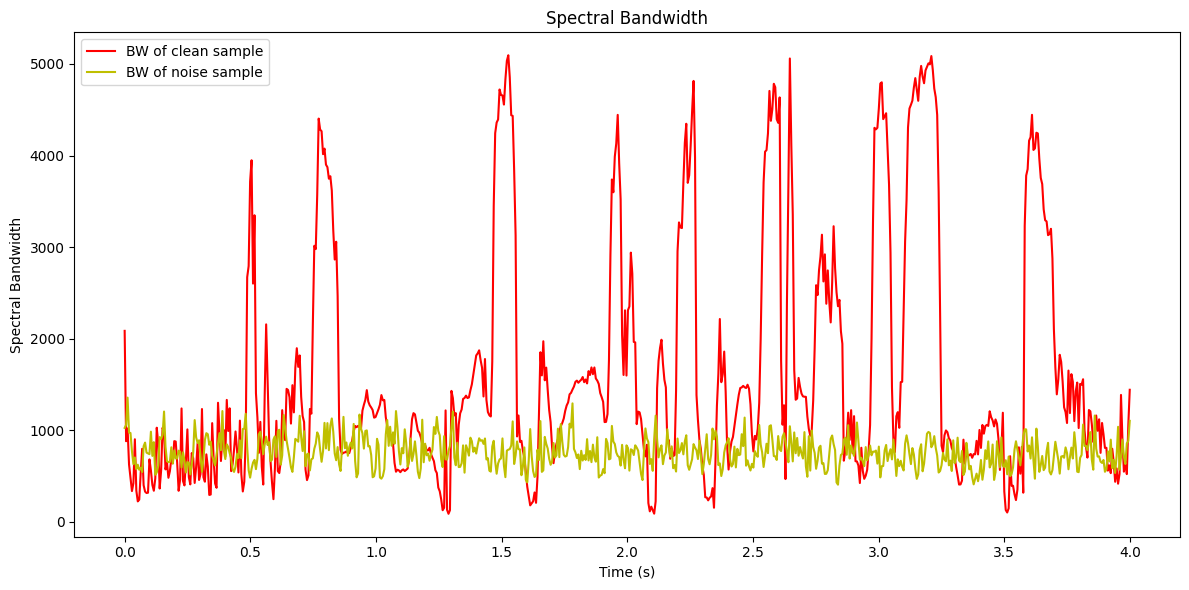

In [74]:
# Convert frame indices to time values
frames = range(len(sc_clean))
time = librosa.frames_to_time(frames, hop_length = HOP_LENGTH)/2


# Plot the spectral centroids

plt.figure(figsize = (12 , 6))
plt.plot(time, sc_clean, color = "r", label = "BW of clean sample")
plt.plot(time, sc_noise, color = "y", label = "BW of noise sample")
plt.title("Spectral Bandwidth")
plt.xlabel("Time (s)")
plt.ylabel("Spectral Bandwidth")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()